# Emerging Topics final code

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

### Data Ingestion

In [2]:
# full corpus
df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

# pandemic corpus
#df = pd.read_pickle("../../data/final/dashboard_data/pandemic_corpus.pkl")
#df.reset_index(inplace=True)

# coronavirus corpus
#df = pd.read_pickle("../../data/final/dashboard_data/corona_corpus.pkl")
#df.reset_index(inplace=True)

In [3]:
df.head()

,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,...,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed
0,17608,152242,The multiprotein complex y-secretase proteolyt...,2008,Active Sites; Affect; Alzheimer's Disease; Amy...,STRUCTURE OF SIGNAL PEPTIDE PEPTIDASE,HHS,NIH,NaN,5F32AG027647-03,...,The multiprotein complex y-secretase proteolyt...,T,1402,g,"[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y_secretase, proteolyt...","[multiprotein, y_secretase, proteolytically_cl..."
1,111864,190316,DESCRIPTION (provided by applicant): The Kis...,2008,Affect; Animal Model; Axon; Behavior; Behavior...,ROLE OF KISS1 NEURONS IN THE SEASONAL AND CIRC...,HHS,NIH,NaN,5K99HD056157-02,...,The Kissl gene encodes peptides called kisspep...,T,2553,y,"[Kissl, gene, encode, peptide, call, kisspepti...","[kissl, gene, encode, peptide, call, kisspepti...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin..."
2,22052,154213,DESCRIPTION (provided by applicant): The objec...,2008,Agreement; Antibodies; base; Binding; Biochemi...,CARBONIC ANHYDRASE AS A MODEL TO UNDERSTAND DI...,HHS,NIH,NaN,5F32GM076971-02,...,The objective of this research is to understan...,T,1414,e,"[objective, research, be, understand, biophysi...","[objective, research, be, understand, biophysi...","[objective, research, understand, biophysical,...","[objective, research, understand, biophysical,...","[objective, research, understand, biophysical,...","[biophysical, basis, thermodynamics_kinetic, m..."
3,35004,159362,Obesity is the cause of many adverse pregnancy...,2008,African; Analysis of Variance; Asians; Birth; ...,OBESITY ON VAGAL TONE AND HBA1C DURING PREGNANCY,HHS,NIH,NaN,5F31NR009611-03,...,Obesity is the cause of many adverse pregnancy...,O,1545,d,"[obesity, cause, many, adverse, pregnancyoutco...","[obesity, cause, many, adverse, pregnancyoutco...","[obesity, cause, adverse, pregnancyoutcome, re...","[obesity, cause, adverse_pregnancyoutcome, res...","[obesity, cause, adverse_pregnancyoutcome, res...","[obesity, adverse_pregnancyoutcome, great, hea..."
4,371628,594482,Local potato advisory groups have expressed in...,2010,cost; Health; interest; Manure; Parasitic nema...,PLANT-PARASITIC NEMATODE MANAGEMENT AS A COMPO...,USDA,NIFA,NaN,0219605,...,Local potato advisory groups have expressed in...,L,271,s,"[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, express, interest, m..."


In [5]:
df.info(memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690814 entries, 0 to 690854
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   original index              690814 non-null  int64  
 1   PROJECT_ID                  690814 non-null  object 
 2   ABSTRACT                    690814 non-null  object 
 3   FY                          690814 non-null  object 
 4   PROJECT_TERMS               688920 non-null  object 
 5   PROJECT_TITLE               690814 non-null  object 
 6   DEPARTMENT                  690814 non-null  object 
 7   AGENCY                      690814 non-null  object 
 8   IC_CENTER                   289225 non-null  object 
 9   PROJECT_NUMBER              690814 non-null  object 
 10  PROJECT_START_DATE          690814 non-null  object 
 11  PROJECT_END_DATE            690814 non-null  object 
 12  CONTACT_PI_PROJECT_LEADER   690773 non-null  object 
 13  OTHER_PIS     

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690814 entries, 0 to 690854
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   original index              690814 non-null  int64  
 1   PROJECT_ID                  690814 non-null  object 
 2   ABSTRACT                    690814 non-null  object 
 3   FY                          690814 non-null  object 
 4   PROJECT_TERMS               688920 non-null  object 
 5   PROJECT_TITLE               690814 non-null  object 
 6   DEPARTMENT                  690814 non-null  object 
 7   AGENCY                      690814 non-null  object 
 8   IC_CENTER                   289225 non-null  object 
 9   PROJECT_NUMBER              690814 non-null  object 
 10  PROJECT_START_DATE          690814 non-null  object 
 11  PROJECT_END_DATE            690814 non-null  object 
 12  CONTACT_PI_PROJECT_LEADER   690773 non-null  object 
 13  OTHER_PIS     

In [7]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_frqwds_removed"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [8]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [9]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [10]:
# use for full dataset
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
tf_idf = tfidf_vectorizer.fit_transform(text)

# use for pandemic or coronavirus dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False)
#tf_idf = tfidf_vectorizer.fit_transform(text)


In [20]:
print(type(tf_idf))
print(tf_idf.dtype)

print(tf_idf.shape)
print(tf_idf.nnz)

<class 'scipy.sparse.csr.csr_matrix'>
float64
(690814, 93627)
63215924


In [22]:
# sparsity %

tf_idf.nnz/(tf_idf.shape[0] * tf_idf.shape[1])

0.00097738180950348

In [23]:
tf_idf.data.nbytes

505727392

In [24]:
print(tf_idf.indptr.nbytes) 
print(tf_idf.indices.nbytes)

2763260
252863696


In [26]:
# total storage in GB

(tf_idf.data.nbytes + tf_idf.indptr.nbytes + tf_idf.indices.nbytes)/ 1000000000

0.761354348

In [8]:
# create model

num_topics = 30 

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 3.3092284202575684


In [9]:
#print_topics(nmf_model, tfidf_vectorizer, 10)

In [40]:
# save nmf model on full dataset

#pickle.dump(nmf_model, open('full_nmf75.sav', 'wb'))


In [9]:
# read in model

#nmf_model = pickle.load(open('full_nmf75.sav', 'rb'))


In [8]:
# full dataset model ingestion so do not have to rerun

num_topics = 75

doc_topic, topic_term = pickle.load(open('final_model_DT_TT.sav','rb'))

### Emerging Topics

In [9]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [10]:
df["START_YEAR"].value_counts()

2009    70341
2010    65365
2011    59286
2008    56170
2012    51579
2014    45773
2016    44917
2015    44798
2013    44227
2018    43224
2017    41733
2019    31166
2007    17863
2006    10504
2005     9521
2004     8038
2003     5093
1997     4507
2002     4486
2001     4406
2000     3635
1999     3475
1998     2677
1996     1851
1994     1598
1995     1436
1992     1269
1993     1179
1991     1136
1988      913
1990      845
1989      840
1987      704
1986      675
1985      665
1978      639
1983      637
1984      598
1977      506
1975      490
1979      463
1980      438
1982      393
1981      341
1976      336
2020       33
1974       32
1970        4
1972        4
1965        4
1973        1
Name: START_YEAR, dtype: int64

In [11]:
df.dtypes

original index                  int64
PROJECT_ID                     object
ABSTRACT                       object
FY                             object
PROJECT_TERMS                  object
PROJECT_TITLE                  object
DEPARTMENT                     object
AGENCY                         object
IC_CENTER                      object
PROJECT_NUMBER                 object
PROJECT_START_DATE             object
PROJECT_END_DATE               object
CONTACT_PI_PROJECT_LEADER      object
OTHER_PIS                      object
CONGRESSIONAL_DISTRICT         object
DUNS_NUMBER                    object
ORGANIZATION_NAME              object
ORGANIZATION_CITY              object
ORGANIZATION_STATE             object
ORGANIZATION_ZIP               object
ORGANIZATION_COUNTRY           object
BUDGET_START_DATE              object
BUDGET_END_DATE                object
CFDA_CODE                      object
FY.y                           object
FY_TOTAL_COST                 float64
FY_TOTAL_COS

In [12]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


In [13]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020]

In [14]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [15]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
0,1965,0.000363,0.000000,0.000100,0.000022,0.000000,0.000006,0.001205,0.000000,0.000387,...,0.012315,0.001820,0.000145,0.000000,0.000055,0.000296,0.008933,0.001642,0.000010,0.000260
1,1970,0.000528,0.000242,0.000025,0.000000,0.000124,0.003027,0.002041,0.001671,0.000000,...,0.000044,0.000362,0.002179,0.002398,0.004706,0.000000,0.000075,0.000031,0.000066,0.004216
2,1972,0.000166,0.002454,0.000226,0.000092,0.000146,0.000072,0.000000,0.000665,0.000612,...,0.000726,0.000768,0.000033,0.009290,0.011979,0.000000,0.000015,0.000000,0.009114,0.000060
3,1973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000416,...,0.000000,0.000000,0.000000,0.000000,0.039855,0.000439,0.000000,0.000000,0.000000,0.000000
4,1974,0.000915,0.000542,0.001042,0.000538,0.001678,0.000957,0.000466,0.001455,0.000905,...,0.002261,0.000683,0.000866,0.000464,0.000765,0.000251,0.001519,0.000281,0.000961,0.003210


In [16]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [17]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
40,2010,0.000518,0.001195,0.001783,0.000584,0.001213,0.000830,0.001048,0.001069,0.000510,...,0.000887,0.001528,0.000903,0.000774,0.000847,0.000893,0.001907,0.000661,0.001849,0.001551
41,2011,0.000509,0.001273,0.001839,0.000600,0.001205,0.000828,0.001212,0.001167,0.000502,...,0.000863,0.001621,0.000907,0.000805,0.000901,0.000842,0.001815,0.000742,0.001857,0.001514
42,2012,0.000519,0.001173,0.001855,0.000590,0.001251,0.000881,0.001140,0.001100,0.000536,...,0.000885,0.001539,0.000922,0.000806,0.000918,0.000901,0.001842,0.000691,0.001632,0.001642
43,2013,0.000483,0.001179,0.002049,0.000567,0.001129,0.000890,0.001560,0.001159,0.000475,...,0.000769,0.001899,0.000853,0.000742,0.000897,0.000798,0.001567,0.000613,0.002075,0.001537
44,2014,0.000488,0.001167,0.001981,0.000581,0.001135,0.000873,0.001308,0.001143,0.000523,...,0.000820,0.001699,0.000907,0.000785,0.000925,0.000854,0.001551,0.000680,0.001813,0.001547
45,2015,0.000476,0.001255,0.001868,0.000591,0.001194,0.000865,0.001342,0.001195,0.000520,...,0.000767,0.001791,0.000861,0.000776,0.000946,0.000808,0.001473,0.000651,0.001804,0.001503
46,2016,0.000463,0.001376,0.001672,0.000549,0.001138,0.000859,0.001149,0.001353,0.000543,...,0.000851,0.001631,0.000866,0.000840,0.001047,0.000806,0.001443,0.000723,0.001661,0.001517
47,2017,0.000496,0.001223,0.001857,0.000590,0.001131,0.000878,0.001205,0.001221,0.000587,...,0.000837,0.001651,0.000845,0.000852,0.000956,0.000842,0.001476,0.000726,0.001638,0.001584
48,2018,0.000493,0.001328,0.001827,0.000616,0.001172,0.000906,0.001054,0.001230,0.000596,...,0.000851,0.001581,0.000848,0.000868,0.000983,0.000850,0.001443,0.000780,0.001440,0.001594
49,2019,0.000539,0.000992,0.001990,0.000653,0.001268,0.000948,0.001207,0.000985,0.000631,...,0.000866,0.001644,0.000887,0.000893,0.000829,0.000933,0.001550,0.000898,0.001441,0.001774


In [18]:
topic_wts_se_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
40,2010,0.000004,0.000015,0.000022,0.000012,0.000019,0.000009,0.000015,0.000010,0.000007,...,0.000018,0.000016,0.000014,0.000015,0.000019,0.000022,0.000022,0.000023,0.000021,0.000022
41,2011,0.000004,0.000016,0.000024,0.000013,0.000019,0.000010,0.000017,0.000012,0.000008,...,0.000019,0.000018,0.000015,0.000017,0.000021,0.000022,0.000022,0.000027,0.000022,0.000023
42,2012,0.000005,0.000017,0.000026,0.000014,0.000021,0.000011,0.000018,0.000012,0.000008,...,0.000020,0.000019,0.000017,0.000017,0.000022,0.000025,0.000025,0.000026,0.000021,0.000026
43,2013,0.000005,0.000018,0.000030,0.000015,0.000021,0.000012,0.000024,0.000014,0.000009,...,0.000020,0.000024,0.000016,0.000018,0.000023,0.000024,0.000023,0.000026,0.000027,0.000027
44,2014,0.000005,0.000018,0.000029,0.000015,0.000021,0.000011,0.000021,0.000013,0.000009,...,0.000020,0.000022,0.000017,0.000019,0.000024,0.000026,0.000023,0.000027,0.000024,0.000026
45,2015,0.000005,0.000019,0.000028,0.000015,0.000022,0.000011,0.000021,0.000014,0.000009,...,0.000019,0.000023,0.000017,0.000019,0.000025,0.000024,0.000022,0.000026,0.000024,0.000026
46,2016,0.000005,0.000020,0.000026,0.000014,0.000021,0.000011,0.000019,0.000015,0.000009,...,0.000021,0.000021,0.000016,0.000020,0.000028,0.000024,0.000022,0.000028,0.000022,0.000026
47,2017,0.000005,0.000019,0.000028,0.000015,0.000022,0.000012,0.000021,0.000015,0.000010,...,0.000021,0.000022,0.000017,0.000021,0.000027,0.000026,0.000022,0.000029,0.000023,0.000027
48,2018,0.000005,0.000020,0.000027,0.000016,0.000022,0.000012,0.000018,0.000014,0.000010,...,0.000020,0.000021,0.000016,0.000021,0.000026,0.000026,0.000022,0.000030,0.000020,0.000026
49,2019,0.000006,0.000021,0.000033,0.000019,0.000026,0.000014,0.000024,0.000015,0.000012,...,0.000024,0.000025,0.000019,0.000025,0.000027,0.000032,0.000026,0.000036,0.000024,0.000032


In [19]:
# perform regressions, track slopes

topic_slopes = []

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
    topic_slopes.append(linear_fit.coef_[0][0])

In [20]:
topic_slopes[:5]

[-6.91390771380066e-07,
 -3.08453870689152e-06,
 3.2826113729421555e-06,
 4.183827488750624e-06,
 -1.5033842969605124e-06]

In [21]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [22]:
hot_cold[:5]

['cold', 'cold', 'hot', 'hot', 'cold']

In [23]:
topic_words = str_topics(topic_term, tfidf_vectorizer, top_n=10)

In [24]:
topic_words[:5]

['cell, differentiation, cellular, antigen, culture, proliferation, human, line, cd4, epithelial',
 'student, undergraduate, graduate, college, faculty, course, summer, reu, career, opportunity',
 'cancer, nci, pancreatic, member, ovarian, prevention, colorectal, colon, oncology, incidence',
 'hiv, aids, infect, prevention, cfar, antiretroviral, art, cd4, transmission, viral',
 'infection, infect, immune, viral, hpv, hcv, parasite, immunity, chronic, tb']

In [25]:
# package up data for data table in RShiny dashboard

reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 


In [26]:
reg_topics

,Slope,Hot or Cold,Topic Words
0,-6.913908e-07,cold,"cell, differentiation, cellular, antigen, cult..."
1,-3.084539e-06,cold,"student, undergraduate, graduate, college, fac..."
2,3.282611e-06,hot,"cancer, nci, pancreatic, member, ovarian, prev..."
3,4.183827e-06,hot,"hiv, aids, infect, prevention, cfar, antiretro..."
4,-1.503384e-06,cold,"infection, infect, immune, viral, hpv, hcv, pa..."
...,...,...,...
70,5.727105e-07,hot,"muscle, skeletal_muscle, exercise, motor, fibe..."
71,-4.902685e-05,cold,"receptor, ligand, bind, activation, gpcr, agon..."
72,1.744426e-05,hot,"pd, parkinson, motor, lrrk2, da, dopamine, dop..."
73,-4.736720e-05,cold,"facility, user, equipment, instrument, laborat..."


In [27]:
#reg_topics.to_csv("./full_topics.csv", index=False)
#reg_topics.to_csv("./pan_topics.csv", index=False)
#reg_topics.to_csv("./cor_topics.csv", index=False)

## Create plots - top 5 hot and cold topics, static plots

In [27]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74
40,2010,0.000518,0.001195,0.001783,0.000584,0.001213,0.000830,0.001048,0.001069,0.000510,...,0.000887,0.001528,0.000903,0.000774,0.000847,0.000893,0.001907,0.000661,0.001849,0.001551
41,2011,0.000509,0.001273,0.001839,0.000600,0.001205,0.000828,0.001212,0.001167,0.000502,...,0.000863,0.001621,0.000907,0.000805,0.000901,0.000842,0.001815,0.000742,0.001857,0.001514
42,2012,0.000519,0.001173,0.001855,0.000590,0.001251,0.000881,0.001140,0.001100,0.000536,...,0.000885,0.001539,0.000922,0.000806,0.000918,0.000901,0.001842,0.000691,0.001632,0.001642
43,2013,0.000483,0.001179,0.002049,0.000567,0.001129,0.000890,0.001560,0.001159,0.000475,...,0.000769,0.001899,0.000853,0.000742,0.000897,0.000798,0.001567,0.000613,0.002075,0.001537
44,2014,0.000488,0.001167,0.001981,0.000581,0.001135,0.000873,0.001308,0.001143,0.000523,...,0.000820,0.001699,0.000907,0.000785,0.000925,0.000854,0.001551,0.000680,0.001813,0.001547
45,2015,0.000476,0.001255,0.001868,0.000591,0.001194,0.000865,0.001342,0.001195,0.000520,...,0.000767,0.001791,0.000861,0.000776,0.000946,0.000808,0.001473,0.000651,0.001804,0.001503
46,2016,0.000463,0.001376,0.001672,0.000549,0.001138,0.000859,0.001149,0.001353,0.000543,...,0.000851,0.001631,0.000866,0.000840,0.001047,0.000806,0.001443,0.000723,0.001661,0.001517
47,2017,0.000496,0.001223,0.001857,0.000590,0.001131,0.000878,0.001205,0.001221,0.000587,...,0.000837,0.001651,0.000845,0.000852,0.000956,0.000842,0.001476,0.000726,0.001638,0.001584
48,2018,0.000493,0.001328,0.001827,0.000616,0.001172,0.000906,0.001054,0.001230,0.000596,...,0.000851,0.001581,0.000848,0.000868,0.000983,0.000850,0.001443,0.000780,0.001440,0.001594
49,2019,0.000539,0.000992,0.001990,0.000653,0.001268,0.000948,0.001207,0.000985,0.000631,...,0.000866,0.001644,0.000887,0.000893,0.000829,0.000933,0.001550,0.000898,0.001441,0.001774


In [28]:
# Sean's plots - legend

leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

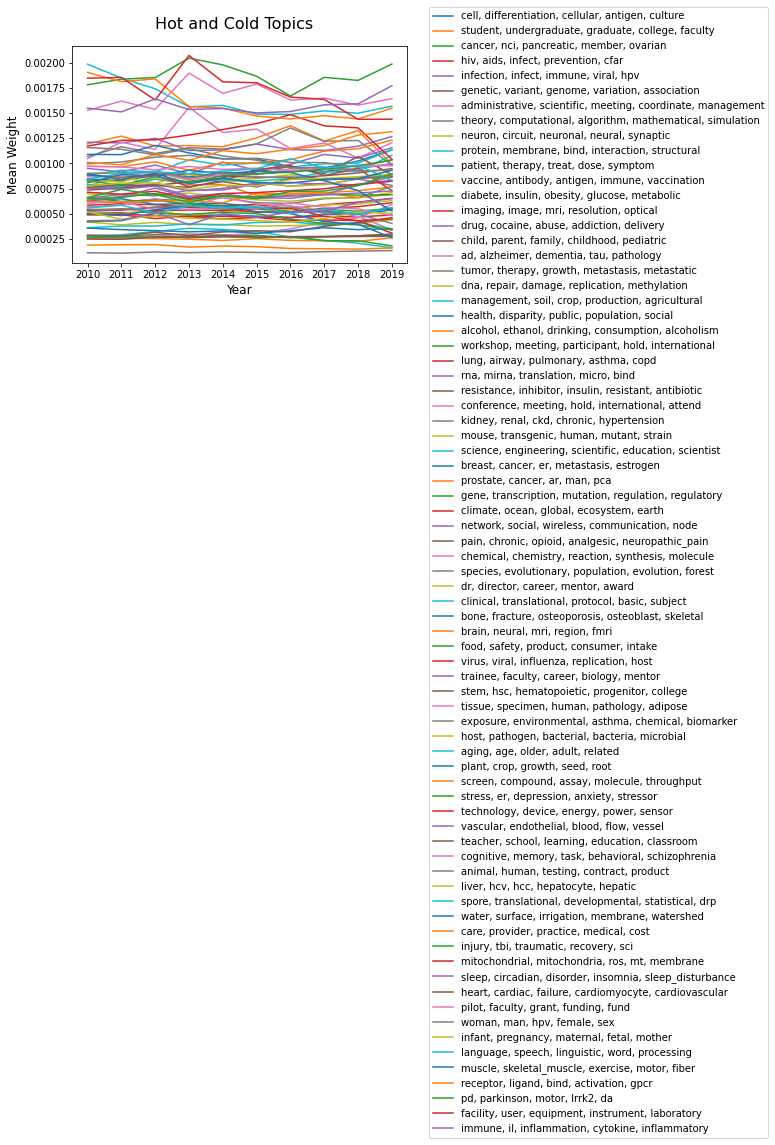

In [29]:
#Make Graphs
#leg = []
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = linear_fit.coef_[0][0]
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [30]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


In [31]:
# {column index, slope} - ex) 1: Topic 0 because Topic 0 is column 1 in the dataframe

#topic_results

In [31]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [32]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]

In [33]:
sort_slopes[:5]

[(62, 3.3683334899886546e-05),
 (17, 3.153637714435134e-05),
 (46, 2.9411393706615253e-05),
 (42, 2.6993445093131538e-05),
 (11, 2.6382139186212044e-05)]

In [34]:
top_slopes

[62, 17, 46, 42, 11]

In [35]:
bottom_slopes

[61, 58, 10, 74, 72]

## plot hottest and coldest on same plot

In [36]:
# for plotting hot and cold on same graph

topnbot_slopes = top_slopes + bottom_slopes

In [37]:
topnbot_slopes

[62, 17, 46, 42, 11, 61, 58, 10, 74, 72]

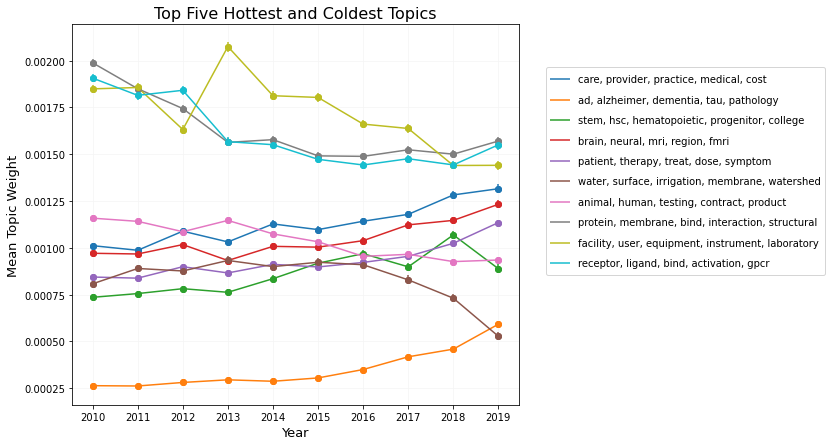

In [46]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topnbot_slopes:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=13)
plt.ylabel('Mean Topic Weight', fontsize=13)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
plt.legend(line_return, [leg[x-1] for x in topnbot_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("figures/updated_full_hot_cold_topics.png", dpi = 800, bbox_inches = "tight")
plt.show()


## Plot hottest and coldest topics on separate plots

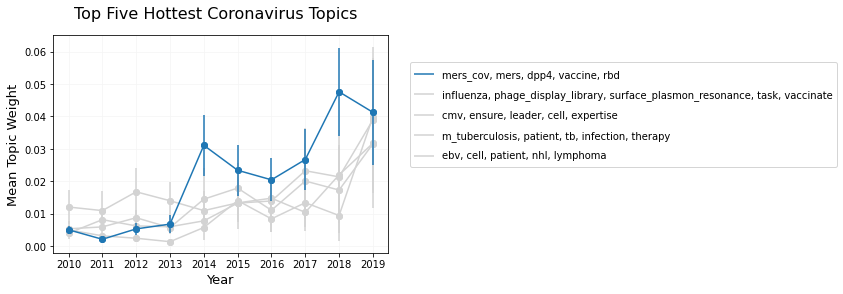

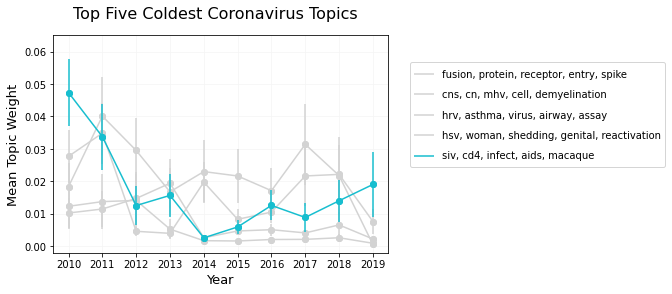

In [40]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]
#color_list = ["#D3D3D3","#2c4f6b","#C0C0C0","#A9A9A9","#808080","#D3D3D3","#2c4f6b","#D3D3D3","#D3D3D3", "#D3D3D3"] #"#fdfdfd"]


line_return = []
fig = plt.figure()
fig.suptitle('Top Five Hottest Coronavirus Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    zorder = 10
    color =   "#D3D3D3"  #color_list[i] 
    if i == 0:
        zorder = 20 #10
        color = color_list[i];
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=13)
plt.ylabel('Mean Topic Weight', fontsize=13)
plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("figures/coronavirus_hot_topics_ex.png", dpi = 800, bbox_inches = "tight")
plt.show()


#Make Graphs
#leg = []

#bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top Five Coldest Coronavirus Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
i = 0
for n in bottom_slopes:
    zorder = 10
    color = "#D3D3D3"  #color_list[i+5]  
    if i == 4:
        zorder = 20 #10
        color = color_list[i+5]
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color=color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=13)
plt.ylabel('Mean Topic Weight', fontsize=13)
plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("figures/coronavirus_cold_topics_ex.png", dpi = 800, bbox_inches = "tight")
plt.show()


In [38]:
bottom_slopes

[72, 74, 10, 58, 61]

In [39]:
[leg[x-1] for x in bottom_slopes]

['receptor, ligand, bind, activation, gpcr',
 'facility, user, equipment, instrument, laboratory',
 'protein, membrane, bind, interaction, structural',
 'animal, human, testing, contract, product',
 'water, surface, irrigation, membrane, watershed']

In [40]:
# save model matrices if needed later

# save to file
topic_term = nmf_model.components_

pickle.dump([doc_topic, topic_term], open('final_model_DT_TT.sav','wb'))

In [40]:
#Melt to get the data for graphing purposes 
#topic_df = topic_frame.melt(id_vars =['START_YEAR'], var_name = "Topic", value_name = "Weight")